In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py
import wandb
# wandb.init(project='evolving-neuroevolution');

In [3]:
work_dir = os.environ['WORK']

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))])
ds_train = torchvision.datasets.MNIST(f'{work_dir}/datasets/mnist', transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=1000, num_workers=0)

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
net = models_pheno.SmallNet()

In [6]:
loss_fn = nn.NLLLoss()
def evaluate_net(net, dl=None, tqdm=None, device=None, verbose=True):
    net = net.to(device)
    n_correct, n_examples = 0, 0
    loss_total = 0
    loop = enumerate(dl)
    if tqdm is not None:
        loop = tqdm(loop, leave=False, total=len(dl))
    for batch_idx, (X_batch, Y_batch) in loop:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        with torch.no_grad():
            Y_batch_pred = net(X_batch)
        n_correct += (Y_batch_pred.argmax(dim=-1)==Y_batch).sum().item()
        loss = loss_fn(Y_batch_pred, Y_batch)
        loss_total += loss.item() * len(X_batch)
        n_examples += len(X_batch)
        if tqdm is not None: loop.set_postfix({'loss':loss.item()})
    loss = loss_total/n_examples
    accuracy = n_correct/n_examples*100.
    if verbose:
        print(f'Average Loss: {loss:.03f}, Accuracy: {accuracy:.03f}%')
    return {'loss': loss, 'accuracy': accuracy}
    
def train_net(net, dl, dl_test=None, n_epochs=10, device=None, lr=1e-2, tqdm=None, verbose=True):
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    losses_train = np.zeros((n_epochs, len(dl)))
    losses_test = np.zeros((n_epochs,))
    params = np.zeros((n_epochs, len(dl), util.count_params(net)))
    loop1 = range(n_epochs)
    if tqdm is not None:
        loop1 = tqdm(loop1, total=n_epochs)
    for epoch_idx in loop1:
        loop2 = enumerate(dl)
        if tqdm is not None:
            loop2 = tqdm(loop2, leave=False, total=len(dl))
        for batch_idx, (X_batch, Y_batch) in loop2:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            Y_batch_pred = net(X_batch)

            loss = loss_fn(Y_batch_pred, Y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            params[epoch_idx, batch_idx, :] = util.model2vec(net).detach().cpu()
            losses_train[epoch_idx, batch_idx] = loss.item()
            if tqdm is not None: loop1.set_postfix({'loss':loss.item()})
        if dl_test is not None:
            data = evaluate_net(net, dl_test, tqdm=tqdm, device=device, verbose=verbose)
            losses_test[epoch_idx] = data['loss']
    return losses_train, losses_test, params

In [ ]:
losses_train_all = []
params_all = []
for i in tqdm(range(1000)):
    net = models_pheno.SmallNet()
    losses_train, losses_val, params = train_net(net, dl_train, dl_test=None, n_epochs=10, 
                                                 device='cuda:0', tqdm=None, verbose=True)
    losses_train_all.append(losses_train)
    params_all.append(params)
params1 = np.stack(params_all)
losses1 = np.stack(losses_train_all)

params.dtype

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
losses_train_all = []
params_all = []
for i in tqdm(range(1000)):
    net = models_pheno.BigConvNet()
    losses_train, losses_val, params = train_net(net, dl_train, dl_test=None, n_epochs=10, 
                                                 device=device, tqdm=None, verbose=True)
    losses_train_all.append(losses_train)
    params_all.append(params)
params2 = np.stack(params_all)
losses2 = np.stack(losses_train_all)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
np.savez('data/smallnet_mnist_optima', params1, losses1)

In [ ]:
np.savez('data/bigconvnet_mnist_optima', params2, losses2)

In [49]:
# a = np.load('data/smallnet_mnist_optima.npz')
a = np.load('data/bigconvnet_mnist_optima.npz')
params, losses = a['arr_0'], a['arr_1']
params, losses = params.astype(np.float32), losses.astype(np.float32)
print(params.shape, losses.shape)

(1000, 10, 60, 2140) (1000, 10, 60)


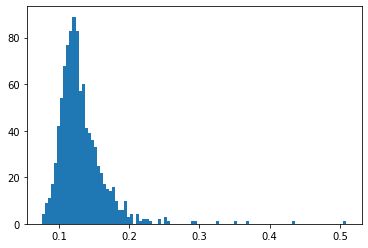

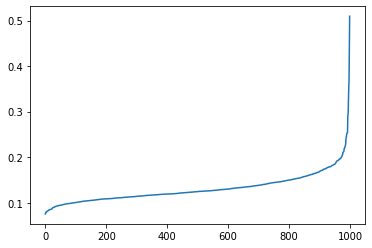

In [50]:
plt.hist(losses[:, -1, -1].flatten(), bins=100);plt.show()
plt.plot(np.sort(losses[:, -1, -1].copy()));plt.show()

In [9]:
params.shape, losses.shape

((1000, 10, 60, 130), (1000, 10, 60))

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
x = params[::50, :, 0, :].reshape(-1, params.shape[-1])
xe = tsne.fit_transform(x)
x = x.reshape(-1, params.shape[-3], x.shape[-1])
xe = xe.reshape(-1, params.shape[-3], 2)
x.shape, xe.shape

((20, 10, 130), (20, 10, 2))

In [12]:
plt.figure(figsize=(20, 20))
for xei in xe:
    plt.scatter(*xei.T, c=np.arange(len(xei)), s=10)
    plt.plot(*xei.T, c='g')
# for xei in xe[success_mask]:
#     plt.scatter(*xei.T, c=np.arange(len(xei)), s=10)
#     plt.plot(*xei.T, c='g')
# for xei in xe[~success_mask]:
#     plt.scatter(*xei.T, c=np.arange(len(xei)), s=10)
#     plt.plot(*xei.T, c='r')
plt.colorbar();
wandb.log({'training trajectories': plt})
plt.close()

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/plotly/matplotlylib/mplexporter/exporter.py:289: MatplotlibDeprecationWarning:


The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



In [57]:
class NetworkDataset(torch.utils.data.Dataset):
    def __init__(self, params, losses, n_agents, ignore_fails=True, sort_by_loss=True):
        super().__init__()
        self.n_agents = n_agents
        self.sort_by_loss = sort_by_loss
        if ignore_fails:
            mask = losses[:, -1, -1]<2.
            params = params[mask]
            losses = losses[mask]
        self.params = torch.from_numpy(params.reshape(-1, params.shape[-1]))
        self.losses = torch.from_numpy(losses.reshape(-1))
    def __len__(self):
        return 100
    def __getitem__(self, idx):
        idx = np.random.choice(len(self.params), size=(self.n_agents,), replace=False)
        if self.sort_by_loss:
            idx = idx[self.losses[idx].argsort()]
        return self.params[idx], self.losses[idx]

In [58]:
params.shape, losses.shape

((1000, 10, 60, 2140), (1000, 10, 60))

In [82]:
n_agents = 5
d = params.shape[-1]

In [67]:
idx = 750
ds_net = NetworkDataset(params[:idx], losses[:idx], n_agents)
dl_net = torch.utils.data.DataLoader(ds_net, batch_size=100)
ds_net_test = NetworkDataset(params[idx:], losses[idx:], n_agents)
dl_net_test = torch.utils.data.DataLoader(ds_net_test, batch_size=100)

In [71]:
net = models_pheno.BigConvNet().to(device)

In [61]:
for x, y in dl_net:
    print(x.shape, y.shape, x.dtype)
for x, y in dl_net_test:
    print(x.shape, y.shape)

torch.Size([100, 5, 2140]) torch.Size([100, 5]) torch.float32
torch.Size([100, 5, 2140]) torch.Size([100, 5])


In [72]:
def modelgrad2vec(model):
    return torch.cat([p.grad.flatten() for p in model.parameters()])

In [73]:
def calc_loss_grad_vec(v, net, x, y):
    net = util.vec2model(v, net)
    for p in net.parameters():
        if p.grad is not None:
            p.grad.zero_()
    yp = net(x)
    loss = loss_fn(yp, y)
    loss.backward()
    return loss.item(), modelgrad2vec(net)

def batch_calc_loss_grad_vec(vs, net, x, y):
    bs, is_ = vs.shape[:-1], vs.shape[-1:]
    vs = vs.reshape(-1, vs.shape[-1])
    losses, grads = [], []
    for v in vs:
        loss, grad = calc_loss_grad_vec(v, net, x, y)
        losses.append(loss)
        grads.append(grad)
    losses, grads = torch.tensor(losses), torch.stack(grads)
    return losses.reshape(*bs), grads.reshape(*bs, *is_)

def calc_grad_div(vs, metric='cossim'):
    vs = vs.detach().clone()
    bs, is_ = vs.shape[:-1], vs.shape[-1:]
    vs.requires_grad_()
    a = vs.reshape(-1, vs.shape[-1])
    if metric=='cossim':
        sim = torch.cosine_similarity(a[None], a[:, None], dim=-1).mean()
    elif metric=='l2':
#         sim = (a[None]-a[:,None]).norm(dim=-1).pow(2).mean()
        sim = (a[None]-a[:,None]).norm(dim=-1).mean()
    sim.backward()
    return sim.item(), vs.grad

In [74]:
x, y = next(iter(dl_train))
x, y = x.to(device), y.to(device)

In [75]:
vs = torch.randn(100, d).to(device)/4.
loss, grad = batch_calc_loss_grad_vec(vs, net, x, y)
print(loss.mean())
vs = torch.from_numpy(params[:100, -1, -1, :]).to(device)
loss, grad = batch_calc_loss_grad_vec(vs, net, x, y)
print(loss.mean())

tensor(3.8698)
tensor(0.1517)


In [76]:
from einops.layers.torch import Rearrange

In [91]:
class CONetConvexComb(nn.Module):
    def __init__(self, fill_value=0.):
        super().__init__()
        self.t = nn.Parameter(torch.full((1,), fill_value))
    def forward(self, x):
        # b, 2, 130
        return self.t*x[:, 0, :] + (1-self.t)*x[:, 1, :]

def CONetLinear(n_agents, init='first'):
    net = nn.Sequential(
        Rearrange('b k w -> b (k w)'),
        nn.Linear(n_agents*130, 130, bias=False),
#         nn.Tanh(),
    )
    if init=='first' or init=='avg':
        net[1].weight.data.zero_()
        if net[1].bias is not None:
            net[1].bias.data.zero_()
    if init=='first':
        net[1].weight.data[:, :130] = torch.eye(130).to(net[1].weight.data)
    if init=='avg':
        for k in range(n_agents):
            net[1].weight.data[:, k*130:(k+1)*130] = 1/n_agents*torch.eye(130).to(net[1].weight.data)
    return net
    

class CONetDeep(nn.Module):
    def __init__(self, n_agents):
        super().__init__()
        self.mod = nn.Sequential(
            Rearrange('b k w -> b (k w)'),
            nn.Linear(n_agents*130, 6*130), nn.GELU(),
            nn.Linear(6*130, 12*130), nn.GELU(),
            nn.Linear(12*130, 12*130), nn.GELU(),
            nn.Linear(12*130, 12*130), nn.GELU(),
            nn.Linear(12*130, 6*130), nn.GELU(),
            nn.Linear(6*130, 3*130), nn.GELU(),
            nn.Linear(3*130, 1*130), nn.Tanh(),
        )
        self.mod[-2].weight.data.zero_()
        self.mod[-2].bias.data.zero_()
    def forward(self, x):
        y = self.mod(x)
        return y+x[:, 0, :]
class CONetDeep(nn.Module):
    def __init__(self, n_agents):
        super().__init__()
        self.mod = nn.Sequential(
            Rearrange('b k w -> b (k w)'),
            nn.Linear(n_agents*d, 6*d), nn.GELU(),
            nn.Linear(6*d, 3*d), nn.GELU(),
            nn.Linear(3*d, 1*d), nn.Tanh(),
        )
        self.mod[-2].weight.data.zero_()
        self.mod[-2].bias.data.zero_()
    def forward(self, x):
        y = self.mod(x)
        return y+x[:, 0, :]
    
class COConvNet(nn.Module):
    def __init__(self, n_agents):
        super().__init__()
        self.mod = nn.Sequential(
#             Rearrange('b k w -> b (k w)'),
            nn.Conv1d(n_agents, 40, 11, padding=5), nn.GELU(),
            nn.Conv1d(40, 40, 11, padding=5), nn.GELU(),
            nn.Conv1d(40, 40, 11, padding=5), nn.GELU(),
            nn.Conv1d(40, 40, 11, padding=5), nn.GELU(),
            nn.Conv1d(40, 40, 11, padding=5), nn.GELU(),
            nn.Conv1d(40, 40, 11, padding=5), nn.GELU(),
            nn.Conv1d(40, 40, 11, padding=5), nn.GELU(),
            nn.Conv1d(40, 40, 11, padding=5), nn.GELU(),
            nn.Conv1d(40, 40, 11, padding=5), nn.GELU(),
            nn.Conv1d(40, 1, 11, padding=5), nn.Tanh(),
        )
        self.mod[-2].weight.data.zero_()
        self.mod[-2].bias.data.zero_()
    def forward(self, x):
        print(x.shape)
        y = self.mod(x)[:, 0, :]
        return y+x[:, 0, :]


# conet = CONetConvexComb(0.5)
# conet = CONetLinear(5)
temp = COConvNet(n_agents)
summary(temp, input_size=(100, n_agents, d))

torch.Size([100, 5, 2140])


Layer (type:depth-idx)                   Output Shape              Param #
COConvNet                                --                        --
├─Sequential: 1-1                        [100, 1, 2140]            --
│    └─Conv1d: 2-1                       [100, 40, 2140]           2,240
│    └─GELU: 2-2                         [100, 40, 2140]           --
│    └─Conv1d: 2-3                       [100, 40, 2140]           17,640
│    └─GELU: 2-4                         [100, 40, 2140]           --
│    └─Conv1d: 2-5                       [100, 40, 2140]           17,640
│    └─GELU: 2-6                         [100, 40, 2140]           --
│    └─Conv1d: 2-7                       [100, 40, 2140]           17,640
│    └─GELU: 2-8                         [100, 40, 2140]           --
│    └─Conv1d: 2-9                       [100, 40, 2140]           17,640
│    └─GELU: 2-10                        [100, 40, 2140]           --
│    └─Conv1d: 2-11                      [100, 40, 2140]          

ideas to try out:


- 2 vs 5 vs 10 vs 20 way uniform crossover
- SGD crossovernet with 1 parent vs 2 parent vs 5 parent
- Conv Crossover trained with bandit-RL/SGD DURING the evolution 

In [86]:
# conet = CONetConvexComb(0.5).to(device)
# conet = CONetLinear(5, init='first').to(device)
conet = CONetDeep(n_agents).to(device)

torch.Size([100, 5]) 0.8913627862930298
torch.Size([100]) 0.6837924122810364


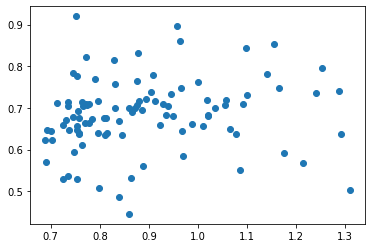

In [25]:
input_weights = next(iter(dl_net))[0].to(device)
output_weights = conet(input_weights)
loss_in, _ = batch_calc_loss_grad_vec(input_weights[:, :, :], net, x, y)
print(loss_in.shape, loss_in.mean().item())
loss_out, _ = batch_calc_loss_grad_vec(output_weights, net, x, y)
print(loss_out.shape, loss_out.mean().item())
# plt.hist(loss_in.cpu().numpy(), bins=100);
plt.scatter(loss_in.mean(dim=-1).cpu().numpy(), loss_out.cpu().numpy())

In [112]:
conet = CONetDeep(5).to(device)
opt = torch.optim.Adam(conet.parameters(), lr=1e-5)

for i in tqdm(range(100000)):
    input_weights = torch.randn(100, 5, 130).to(device)
    output_weights = conet(input_weights)
    
    loss = (input_weights[:, 0, :]-output_weights).pow(2).mean()
    opt.zero_grad()
    loss.backward()
    
    
#     loss, grad_div = calc_grad_div(output_weights)
#     output_weights.backward(grad_div)
#     loss = (input_weights[:, 0, :]-output_weights).pow(2).mean()
#     loss.backward()
#     loss = loss.item()
    
    opt.step()
    if i%1000==0:
        print(loss.item())

  0%|          | 0/100000 [00:00<?, ?it/s]

1.0092406272888184
0.814268171787262
0.6656336784362793
0.5977120399475098
0.5329130291938782
0.4644031524658203
0.431257963180542
0.3920382261276245
0.35515880584716797
0.32912197709083557
0.3035390079021454
0.29335492849349976
0.27218008041381836
0.2478344738483429
0.2449192851781845
0.23414890468120575
0.21894831955432892
0.2145439237356186
0.20843246579170227
0.20000077784061432
0.19005194306373596
0.18919357657432556
0.18623076379299164
0.18621127307415009
0.18422070145606995
0.19273073971271515
0.18548564612865448
0.18116098642349243
0.18342554569244385
0.18388484418392181
0.1892004907131195
0.18678975105285645
0.178167924284935
0.18241260945796967
0.17793093621730804
0.1769511103630066
0.1787193864583969
0.1735578328371048
0.18022340536117554
0.17160621285438538
0.17653928697109222


KeyboardInterrupt: 

In [22]:
conet = CONetDeep(5).to(device)

In [33]:
conet = CONetDeep(5).to(device)
opt = torch.optim.Adam(conet.parameters(), lr=1e-5)

loop = tqdm(range(50_000))
for i in loop:
    input_weights = torch.randn(1000, 5, 130).to(device)
    output_weights = conet(input_weights)
    
    opt.zero_grad()
    
#     loss, grad_div = calc_grad_div(output_weights)
#     output_weights.backward(grad_div)
    loss = (input_weights[:, 0, :]-output_weights).pow(2).mean()
    loss.backward()
    loss = loss.item()

    opt.step()
    
#     wandb.log({'pretraining loss': loss})
    loop.set_postfix({'loss':loss})

  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [117]:
old_conet = conet

In [26]:
def print_conet_statistics(input_weights, conet):
    x, y = [x.to(device) for x in next(iter(dl_train))]
    input_weights = input_weights.to(device)
    output_weights = conet(input_weights)
    loss_in, _ = batch_calc_loss_grad_vec(input_weights[:, :, :], net, x, y)
    loss_out, _ = batch_calc_loss_grad_vec(output_weights, net, x, y)
    l2_in = calc_grad_div(input_weights[:, 0, :], metric='l2')[0]
    cossim_in = calc_grad_div(input_weights[:, 0, :], metric='cossim')[0]
    l2_out = calc_grad_div(output_weights, metric='l2')[0]
    cossim_out = calc_grad_div(output_weights, metric='cossim')[0]
    print(f'p avg->child: {loss_in.mean().item():04f}->{loss_out.mean().item():04f}')
    print(f'p min->child: {loss_in.min(dim=-1).values.mean().item():04f}->{loss_out.mean().item():04f}')
    print(f'l2          : {l2_in:04f}->{l2_out:04f}')
    print(f'cossim      : {cossim_in:04f}->{cossim_out:04f}')
    return loss_in, loss_out, cossim_in, cossim_out
    



In [28]:
input_weights = torch.randn(100, n_agents, 130).to(device)
print_conet_statistics(input_weights, conet)

input_weights, loss_in = [x.to(device) for x in next(iter(dl_net))]
print_conet_statistics(input_weights, conet);

p avg->child: 55.229366->57.684036
p min->child: 4.867018->57.684036
l2          : 15.873187->15.873187
cossim      : 0.010094->0.010094
p avg->child: 0.878480->0.674106
p min->child: 0.652576->0.674106
l2          : 7.402922->7.402922
cossim      : 0.121581->0.121581


In [124]:
trained_conet = conet

In [67]:
# wandb.init(project='evolving-neuroevolution', id='akrun')

In [32]:
import copy
conet = copy.deepcopy(old_conet)

NameError: name 'old_conet' is not defined

In [93]:
run = wandb.init()

In [94]:
conet = CONetDeep(n_agents).to(device)

In [95]:
wandb.watch(conet)

In [ ]:
net = net.to(device)
# conet = CONetConvexComb(0.6)
# conet = CONetLinear(5, init='first').to(device)
# conet = CONetDeep(5).to(device)
# opt = torch.optim.Adam(conet.parameters(), lr=1e-2)
opt = torch.optim.Adam(conet.parameters(), lr=1e-4)

loop = tqdm(range(10000))
for epoch_idx in loop:
    x, y = next(iter(dl_train))
    x, y = x.to(device), y.to(device)
    
    if epoch_idx%50==0:
        for dl, name in zip([dl_net, dl_net_test], ['Training', 'Testing']):
            print(f'--------{name}-----')
            input_weights, loss_in = [x.to(device) for x in next(iter(dl))]
            loss_in, loss_out, cossim_in, cossim_out = print_conet_statistics(input_weights, conet)
            wandb.log({f'{name}_loss_in': loss_in.min(dim=-1).values,
                       f'{name}_loss_out': loss_out,
                       f'{name}_cossim_in': cossim_in,
                       f'{name}_cossim_out': cossim_out,
                       })
        print()
        
    for batch_idx, (input_weights, input_losses) in enumerate(dl_net):
        input_weights, input_losses = input_weights.to(device), input_losses.to(device)
        output_weights = conet(input_weights)
        
        loss, grad = batch_calc_loss_grad_vec(output_weights, net, x, y)
#         loss_div, grad_div = calc_grad_div(output_weights)
#         loss_div, grad_div2 = calc_.pow(2)grad_div(output_weights, metric='l2')
        
        a = input_weights[:, 0, :]
        cossim_in = torch.cosine_similarity(a[None], a[:, None], dim=-1).mean()
        a = output_weights.detach().clone().requires_grad_()
        cossim_out = torch.cosine_similarity(a[None], a[:, None], dim=-1).mean()
        (cossim_out-cossim_in).relu().backward()
        grad_div = a.grad

        opt.zero_grad()
#         output_weights.backward(1e-4*grad+1*grad_div)
        output_weights.backward(1e-4*grad)
        opt.step()
        
        loop.set_postfix({'loss': loss.mean().item()})
#         print(loss.mean().item())
        wandb.log({'loss':loss.mean().item(), 
                   'cossim_in': cossim_in.item(), 
                   'cossim_out': cossim_out.item()})
    
#     plt.figure(figsize=(30, 20))
#     plt.subplot(211)
#     plt.imshow(conet[1].weight.detach().cpu().numpy(), vmin=-1, vmax=1)
#     plt.colorbar()
#     plt.subplot(212)
#     plt.imshow(np.tile(conet[1].bias.detach().cpu().numpy(), [10, 1]), vmin=-1, vmax=1)
#     plt.colorbar()
#     plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

--------Training-----
p avg->child: 0.333894->0.154001
p min->child: 0.145012->0.154001
l2          : 14.292688->14.292688
cossim      : 0.020555->0.020555
--------Testing-----
p avg->child: 0.293194->0.150165
p min->child: 0.140680->0.150165
l2          : 14.155507->14.155507
cossim      : 0.023983->0.023983

--------Training-----
p avg->child: 0.319606->0.153454
p min->child: 0.135855->0.153454
l2          : 14.132943->14.134934
cossim      : 0.021836->0.021801
--------Testing-----
p avg->child: 0.341082->0.151559
p min->child: 0.142911->0.151559
l2          : 14.090919->14.090665
cossim      : 0.022039->0.021953

--------Training-----
p avg->child: 0.302115->0.159402
p min->child: 0.140620->0.159402
l2          : 14.224740->14.229630
cossim      : 0.019685->0.019692
--------Testing-----
p avg->child: 0.310494->0.150972
p min->child: 0.139765->0.150972
l2          : 14.339209->14.341103
cossim      : 0.024474->0.024516

--------Training-----
p avg->child: 0.299488->0.171198
p min->ch

In [80]:
output_weights.shape, input_weights.shape

(torch.Size([100, 130]), torch.Size([100, 5, 130]))

In [87]:
print(torch.cosine_similarity(output_weights[:, None], input_weights, dim=-1).min(dim=-1).values.mean())
print(torch.cosine_similarity(output_weights[:, None], input_weights, dim=-1).max(dim=-1).values.mean())

print((output_weights[:, None]- input_weights).norm(dim=-1).min(dim=-1).values.mean())
print((output_weights[:, None]- input_weights).norm(dim=-1).max(dim=-1).values.mean())

tensor(-0.1944, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3704, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2059, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.2232, device='cuda:0', grad_fn=<MeanBackward0>)


In [88]:
output_weights.norm(dim=-1).mean()

tensor(7.3583, device='cuda:0', grad_fn=<MeanBackward0>)

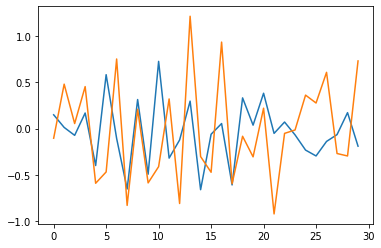

In [93]:
plt.plot(input_weights[0,0].detach().cpu().numpy()[30:60]);
plt.plot(output_weights[0].detach().cpu().numpy()[30:60]);

In [51]:
a = torch.from_numpy(params[:, -1, -1, :])

In [55]:
b = torch.cosine_similarity(a[:, None], a[None], dim=-1)
(b>.5).sum()

tensor(1000)

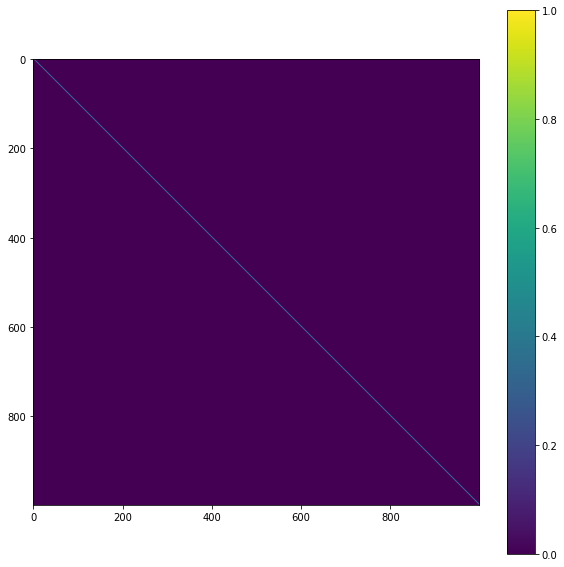

In [56]:
plt.figure(figsize=(10,10))
plt.imshow(b.numpy()>.5)
plt.colorbar()

In [264]:
# input_weights, loss_in = [x.to(device) for x in next(iter(dl_net))]
input_weights = torch.from_numpy(params[:500, -1, 0].reshape(-1, 5, 130)).to(device)
output_weights = conet(input_weights)
loss_in, _ = batch_calc_loss_grad_vec(input_weights[:, :, :], net, x, y)
loss_out, _ = batch_calc_loss_grad_vec(output_weights, net, x, y)
l2_in = calc_grad_div(input_weights[:, 0, :], metric='l2')[0]
cossim_in = calc_grad_div(input_weights[:, 0, :], metric='cossim')[0]
l2_out = calc_grad_div(output_weights, metric='l2')[0]
cossim_out = calc_grad_div(output_weights, metric='cossim')[0]
print(loss_in.min(dim=-1).values.mean(), loss_out.mean())

tensor(0.6262) tensor(1.0461)


In [231]:
loss_in.min(dim=-1).values.mean(), loss_out.mean()

(tensor(0.6685), tensor(0.5952))

In [239]:
loss_in[loss_in.min(dim=-1).values> loss_out].min(dim=-1).values

tensor([0.6476, 0.5772, 0.6508, 0.6407, 0.6161, 0.6105, 0.7347, 0.6731, 0.7173,
        0.6519, 0.6871, 0.6435, 0.6523, 0.5608, 0.6322, 0.6699, 0.6768, 0.6485,
        0.7742, 0.7765, 0.6325, 0.6827, 0.6596, 0.6842, 0.6540, 0.6133, 0.6796,
        0.5034, 0.6442, 0.6671, 0.6180, 0.6282, 0.6555, 0.6393, 0.6795, 0.8204,
        0.6818, 0.5433, 0.6399, 0.7073, 0.5888, 0.7722, 0.7071, 0.8134, 0.6901,
        0.6609, 0.6886, 0.7910, 0.7337, 0.7632, 0.5136, 0.7402, 0.7036, 0.5584,
        0.7512, 0.5506, 0.6406, 0.6283, 0.5756, 0.7565, 0.6444, 0.7119, 0.7010,
        0.6920, 0.7361, 0.6754, 0.7173, 0.6198, 0.7243, 0.6488, 0.5725, 0.7151,
        0.6906, 0.7694, 0.8529, 0.4442, 0.6767, 0.6714, 0.7025, 0.7233, 0.6898,
        0.7583, 0.6810, 0.6467, 0.6621, 0.6319, 0.6346, 0.6302, 0.6734])

In [232]:
cossim_in, cossim_out

(0.11832845211029053, 0.14092256128787994)

In [241]:
input_weights.shape, output_weights.shape

(torch.Size([100, 5, 130]), torch.Size([100, 130]))

In [253]:
sim = torch.cosine_similarity(input_weights, output_weights[:, None], dim=-1)
# sim = torch.cosine_similarity(input_weights, input_weights[:, [0]], dim=-1)

In [254]:
sim.mean(dim=0)

tensor([0.9053, 0.1059, 0.0443, 0.0573, 0.0489], device='cuda:0',
       grad_fn=<MeanBackward1>)

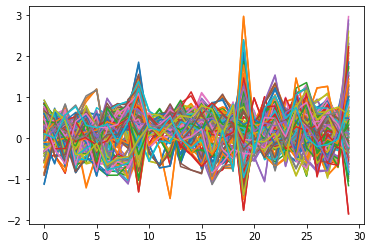

In [222]:
plt.plot(input_weights[:, 0, :].detach().cpu().numpy()[:, 0:30].T);
plt.plot(output_weights.detach().cpu().numpy()[:, 0:30].T);

In [99]:
input_weights = []
for _ in tqdm(range(15)):
    net = models_pheno.SmallNet() 
    _, _, _ = train_net(net, dl_train, n_epochs=1, device='cuda:1', tqdm=partial(tqdm, leave=False))
    input_weights.append(util.model2vec(net))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [103]:
input_weights = torch.stack(input_weights).detach().to(device)

In [107]:
input_weights_original = input_weights

In [125]:
idx = torch.randint(low=0, high=len(input_weights_original), size=(100, 5))
input_weights = input_weights_original[idx]

In [157]:
output_weights = conet(input_weights)
loss_in, _, _ = batch_calc_loss_grad_vec(input_weights.reshape(-1, 130), net.to(device), x, y)
loss_in = loss_in.reshape(-1, 5)
print(loss_in.mean().item())
loss_out, _, _ = batch_calc_loss_grad_vec(output_weights, net, x, y)
print(loss_out.mean().item())
# plt.hist(loss_in.cpu().numpy(), bins=100);

1.756570816040039
1.4465947151184082


torch.Size([100, 5]) torch.Size([100])


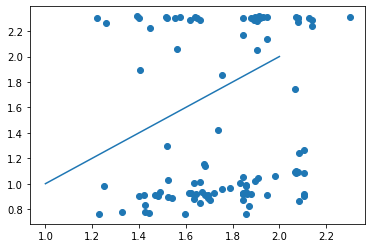

In [163]:
print(loss_in.shape, loss_out.shape)
plt.scatter(loss_in.cpu().numpy().mean(axis=-1), loss_out.cpu().numpy())
plt.plot([1, 2], [1,2])

In [204]:
mask = (loss_in>2.).all(axis=-1)

In [206]:
loss_in[mask], loss_out[mask]

(tensor([[2.3005, 2.3007, 2.3012, 2.3005, 2.3009]]), tensor([2.3113]))

In [207]:
output_weights[mask].shape

torch.Size([1, 130])

In [210]:
loss_in.mean(), loss_out.mean()

(tensor(1.7566), tensor(1.4466))

In [211]:
loss_in[mask].mean(), loss_out[mask].mean()

(tensor(2.3008), tensor(2.3113))

In [212]:
loss_in.min(dim=-1).values.mean(), loss_out.mean()

(tensor(1.2012), tensor(1.4466))

In [213]:
input_weights.shape, output_weights.shape

(torch.Size([100, 5, 130]), torch.Size([100, 130]))

In [215]:
sim = torch.cosine_similarity(input_weights, output_weights[:, None, :], dim=-1)

In [225]:
sim.max(dim=-1).values, sim.min(dim=-1).values

(tensor([0.2202, 0.5432, 0.0473, 0.0573, 0.1120, 0.2695, 0.3109, 0.2302, 0.2432,
         0.0497, 0.5267, 0.0748, 0.1201, 0.1181, 0.3083, 0.2716, 0.2953, 0.1133,
         0.5269, 0.3059, 0.3744, 0.5434, 0.3275, 0.5381, 0.5273, 0.0503, 0.3479,
         0.3388, 0.5362, 0.0869, 0.2648, 0.2692, 0.1266, 0.4050, 0.1299, 0.0678,
         0.5421, 0.5679, 0.0708, 0.2136, 0.3497, 0.0791, 0.3079, 0.1004, 0.3494,
         0.3393, 0.1323, 0.1118, 0.1438, 0.0584, 0.3731, 0.2248, 0.3522, 0.1368,
         0.2731, 0.3132, 0.2966, 0.3695, 0.2049, 0.0587, 0.5680, 0.1472, 0.3314,
         0.5276, 0.3016, 0.2642, 0.3043, 0.3018, 0.0453, 0.1580, 0.2976, 0.3881,
         0.1065, 0.3782, 0.0592, 0.2001, 0.2469, 0.5642, 0.1137, 0.2230, 0.1161,
         0.2707, 0.0511, 0.1856, 0.3374, 0.2288, 0.3084, 0.5421, 0.1962, 0.1431,
         0.5718, 0.5468, 0.3031, 0.2709, 0.3739, 0.1013, 0.1332, 0.3384, 0.1968,
         0.3722], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([-3.1049e-01, -3.6950e-01, -7.4434e-02, -

In [193]:
output_weights.shape

torch.Size([100, 130])

l2    :  7.649548053741455
cossim:  0.0890999585390091


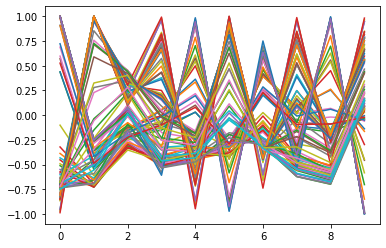

In [194]:
a = output_weights
print('l2    : ', (a[None]-a[:, None]).norm(dim=-1).mean().item())
print('cossim: ', torch.cosine_similarity(a[None], a[:, None], dim=-1).mean().item())

plt.plot(output_weights.detach().cpu().numpy()[:, :10].T);

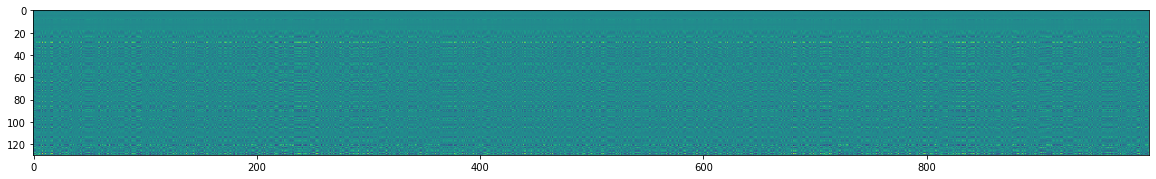

In [42]:
plt.figure(figsize=(20, 10))
plt.imshow(output_weights.detach().cpu().numpy().T)

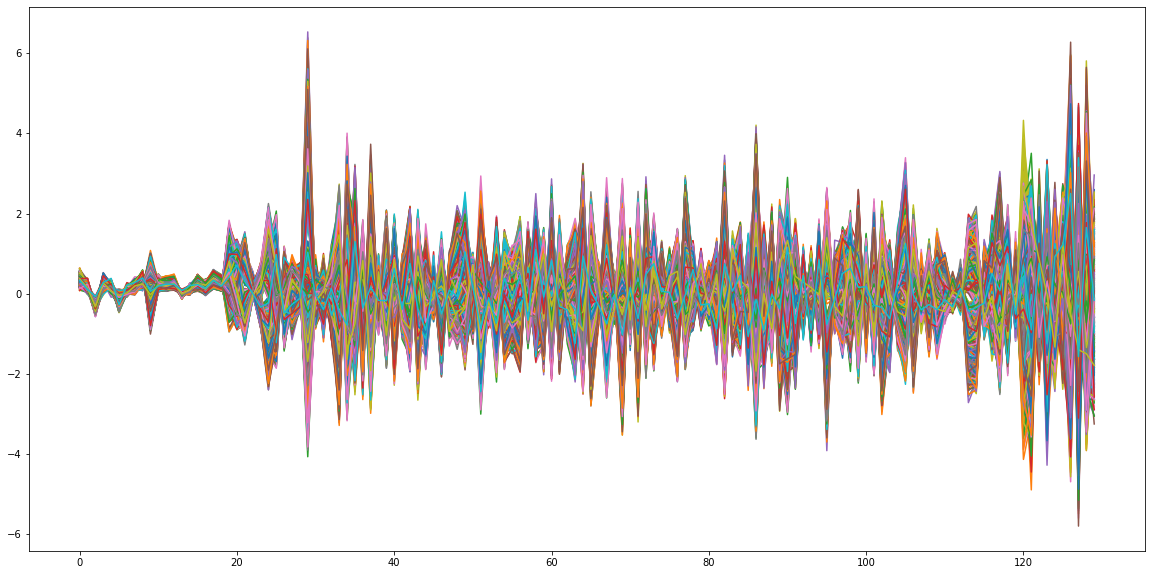

In [58]:
plt.figure(figsize=(20, 10))
plt.plot(output_weights.detach().cpu().numpy().T);
# plt.plot(output_weights.detach().cpu().numpy()[1])
# plt.plot(output_weights.detach().cpu().numpy()[2])
# plt.plot(output_weights.detach().cpu().numpy()[3])
# plt.plot(output_weights.detach().cpu().numpy()[4])

In [70]:
input_weights[0,0],output_weights[0]

(tensor([ 7.4693e-01,  1.2165e-01,  2.0820e-01,  3.5916e-01,  4.7012e-01,
          4.0357e-01,  1.0776e-02,  5.4865e-01,  4.5129e-01,  3.0006e-01,
         -1.1181e-01, -3.5508e-01, -2.5973e-01,  2.7665e-01, -3.6615e-01,
          2.3189e-01,  3.2683e-01,  3.3569e-01,  5.2556e-01,  2.4814e-01,
         -8.3754e-02,  4.5437e-03, -4.1117e-01,  4.1022e-01, -1.5042e-02,
          7.6836e-02,  8.1089e-02,  5.1904e-02,  5.8464e-01, -3.7106e-02,
         -5.7762e-01, -1.0243e-01, -7.3652e-01,  1.7609e-01,  2.8473e-01,
         -6.5335e-01,  3.7655e-01,  8.3813e-02, -4.4970e-04,  4.0037e-01,
         -2.9720e-01, -1.8123e-01, -1.5849e-01,  1.7044e-01, -2.7017e-01,
         -4.8093e-01,  3.1219e-01,  7.0657e-02, -4.1947e-01, -3.3794e-01,
         -2.5350e-01,  3.6769e-01,  1.4120e-01,  3.6566e-01, -2.0327e-01,
         -1.7254e-02, -4.1277e-02, -6.0622e-01, -2.5643e-01,  1.2556e-01,
         -3.0901e-01,  2.3889e-01,  3.2793e-01,  1.9183e-01,  1.3873e-01,
         -5.9129e-01,  4.7395e-01,  4.

In [72]:
torch.save(conet, 'conet.th')

In [29]:
conet = torch.load('conet.th')

In [172]:
next(iter(dl_net_test))[0].mean(axis=-1).flatten().shape

torch.Size([300])

In [173]:
next(iter(dl_net))[0].mean(axis=-1).flatten().shape

torch.Size([3000])

In [41]:
x, y = next(iter(dl_train))
x, y = x.to(device), y.to(device)

input_weights = next(iter(dl_net_test))[0].to(device)
# input_weights = torch.randn_like(input_weights)/4.
output_weights = conet(input_weights)

loss, grad, grad_div = batch_calc_loss_grad_vec(input_weights[:, 0, :], net, x, y)
print(loss.mean().item())
loss, grad, grad_div = batch_calc_loss_grad_vec(output_weights, net, x, y)
print(loss.mean().item())

1.5293023586273193
0.7836205959320068


In [133]:
input_weights = []
for i in tqdm(range(30)):
    net = models_pheno.SmallNet().to(device)
#     input_weights.append(util.model2vec(net).clone())
    a, _, _ = train_net(net, dl_train, n_epochs=1, device=device, tqdm=None)
    if a is not None:
        input_weights.append(util.model2vec(net).clone())
#     input_weights.append(torch.randn_like(input_weights[0])/4.)
input_weights = torch.stack(input_weights)

  0%|          | 0/30 [00:00<?, ?it/s]

2.30238676071167
FAIL
2.30216121673584
FAIL
0.8641133308410645
0.9737995862960815
2.3020248413085938
FAIL
1.0399041175842285
1.0586174726486206
2.302520513534546
FAIL
2.301753282546997
FAIL
1.2768208980560303
0.8474970459938049
2.3017351627349854
FAIL
2.3022007942199707
FAIL
1.4780112504959106
1.3438340425491333
1.2639224529266357
1.4366066455841064
2.3021504878997803
FAIL
1.2670212984085083
1.2244071960449219
1.0416382551193237
2.301973342895508
FAIL
1.0509116649627686
1.8959872722625732
0.9961934685707092
2.302586078643799
FAIL
2.302304744720459
FAIL
1.0428637266159058
1.052196979522705
0.9851279854774475


In [136]:
input_weights = input_weights[torch.randint(low=0, high=len(input_weights), size=(1500,))]

In [176]:
# input_weights = next(iter(dl_net_test))[0].to(device)
input_weights = iw
output_weights = conet(input_weights)

loss_in, grad, grad_div = batch_calc_loss_grad_vec(input_weights[:, 0, :], net, x, y)
print(loss_in.mean().item())
loss_out, grad, grad_div = batch_calc_loss_grad_vec(output_weights, net, x, y)
print(loss_out.mean().item())

EinopsError:  Error while computing Rearrange('b k w -> b (k w)')
 Expected 3 dimensions, got 2

In [143]:
loss_in = loss_in.reshape(500, 3)

In [144]:
loss_in.shape, loss_out.shape

(torch.Size([500, 3]), torch.Size([500]))

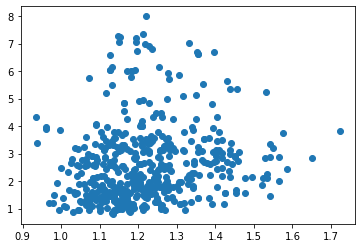

In [156]:
plt.scatter(loss_in.numpy().mean(axis=-1), loss_out.numpy())
# plt.errorbar(x=loss_in.numpy().mean(axis=-1), 
#              y=loss_out.numpy(),
#              xerr=loss_in.numpy().std(axis=-1), fmt='o')

In [ ]:
# 

In [180]:
x, y = next(iter(dl_train))
x, y = x.to(device), y.to(device)

input_weights = next(iter(dl_net))[0].to(device)
output_weights = conet(input_weights)

loss, grad = batch_calc_loss_grad_vec(input_weights[:, 0, :], net, x, y)
print(loss.mean().item())
loss, grad = batch_calc_loss_grad_vec(output_weights, net, x, y)
print(loss.mean().item())

1.3004553318023682
0.5270594358444214


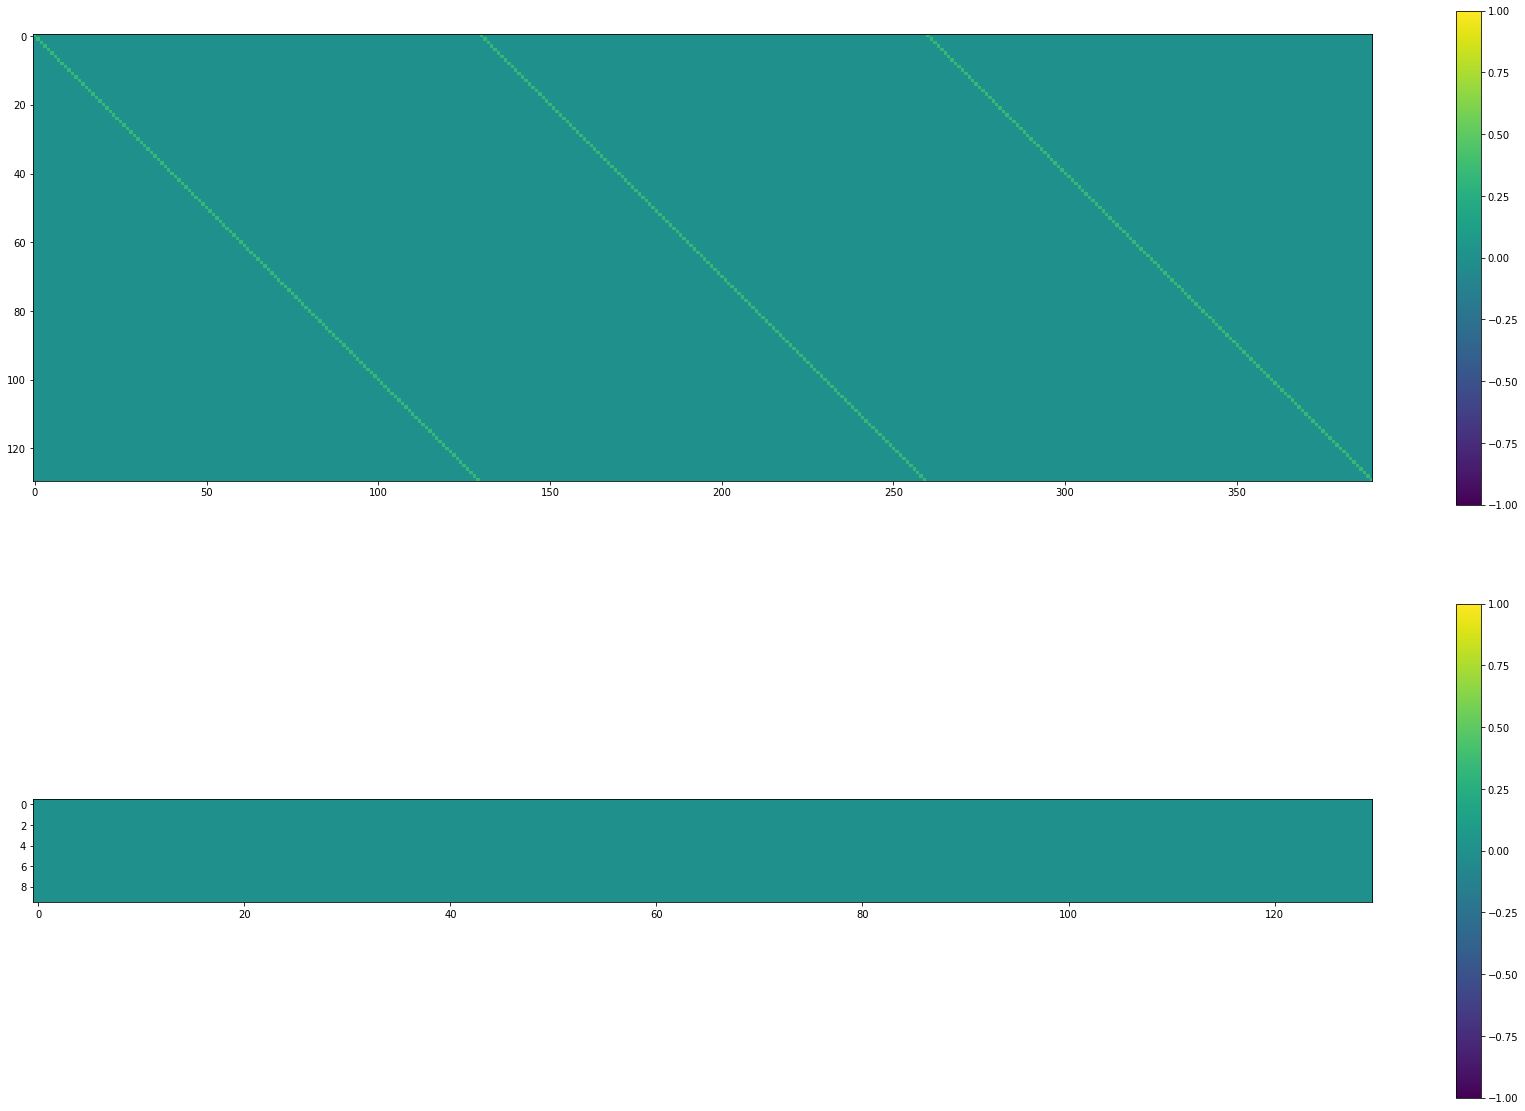

In [118]:
conet = CONetLinear(init_first=True)
plt.figure(figsize=(30, 20))
plt.subplot(211)
plt.imshow(conet[1].weight.detach().cpu().numpy(), vmin=-1, vmax=1)
plt.colorbar()
plt.subplot(212)
plt.imshow(np.tile(conet[1].bias.detach().cpu().numpy(), [10, 1]), vmin=-1, vmax=1)
plt.colorbar()
plt.show()


In [278]:
net = net.to(device)
weights = (torch.randn(130)/4).to(device).requires_grad_()
opt = torch.optim.Adam([weights], lr=1e-2)
opt2 = torch.optim.Adam(net.parameters(), lr=1e-2)

loop1 = range(1)
for epoch_idx in loop1:
    loop2 = enumerate(dl_train)
    for batch_idx, (X_batch, Y_batch) in loop2:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        net = util.vec2model(weights, net)
        Y_batch_pred = net(X_batch)

        loss = loss_fn(Y_batch_pred, Y_batch)
        
        opt.zero_grad()
        opt2.zero_grad()
        
        loss.backward()
        weights.backward(modelgrad2vec(net))
#         weights.grad = modelgrad2vec(net)
        
        opt.step()
        
        print(loss.item())

2.3129842281341553
2.3111631870269775
2.3031930923461914
2.310865879058838
2.3003385066986084
2.2995967864990234
2.2982120513916016
2.3040382862091064
2.28479266166687
2.285640239715576
2.278459310531616
2.2652580738067627
2.269397020339966
2.2694668769836426
2.2637555599212646
2.2544703483581543
2.250048875808716
2.23844051361084
2.221872329711914
2.23321270942688
2.20637845993042
2.213125467300415
2.201493978500366
2.2000131607055664
2.1698780059814453
2.164766550064087
2.156481981277466
2.149627923965454
2.1229500770568848
2.093980312347412
2.125466823577881
2.098940849304199
2.078906536102295
2.04414701461792
2.0532658100128174
2.0521843433380127
2.010922908782959
1.9878333806991577
1.9750975370407104
1.9774733781814575
1.917434573173523
1.9992127418518066
1.9874861240386963
1.8766132593154907
1.9555143117904663
1.9266071319580078
1.9194003343582153
1.8079317808151245
1.7628238201141357
1.908777117729187
1.7909170389175415
1.764322280883789
1.7615859508514404
1.6544173955917358
1.7

In [70]:
losses_train, losses_val, params = train_net(net, dl_train, dl_test=dl_train, n_epochs=1, device='cuda', tqdm=tqdm, verbose=True)
evaluate_net(net, dl_train, tqdm, device='cuda', verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Average Loss: 0.536, Accuracy: 83.530%


  0%|          | 0/60 [00:00<?, ?it/s]

Average Loss: 0.536, Accuracy: 83.530%


{'loss': 0.535942442715168, 'accuracy': 83.53}

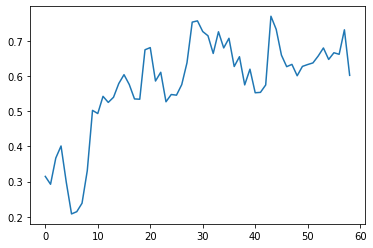

In [71]:
v = params[-1, :] - params[0, :]

sims = []
for i in range(len(params)-1):
    vp = params[i+1, :]-params[i, :]
    sims.append(torch.cosine_similarity(v, vp, dim=0).item())
plt.plot(sims)

In [165]:
def uniform_crossover(vs):
    n = len(vs)
    d = vs.shape[-1]
    ans = torch.zeros(d)
    idx = np.random.choice(n, size=d)
    ans = vs[idx, np.arange(d)]
    return ans

In [181]:
top_n = 70

In [182]:
pop = torch.randn(100, 2000)
for i in range(10):
    print(torch.cosine_similarity(pop[None], pop[:, None], dim=-1).mean())
    pop = torch.stack([uniform_crossover(vs) for vs in pop[np.random.choice(top_n, size=(100, 2))]])

tensor(0.0102)
tensor(0.0240)
tensor(0.0378)
tensor(0.0519)
tensor(0.0656)
tensor(0.0799)
tensor(0.0914)
tensor(0.1060)
tensor(0.1217)
tensor(0.1379)


In [183]:
pop = torch.randn(100, 2000)
for i in range(10):
    print(torch.cosine_similarity(pop[None], pop[:, None], dim=-1).mean())
    pop = torch.stack([uniform_crossover(vs) for vs in pop[np.random.choice(top_n, size=(100, 50))]])

tensor(0.0098)
tensor(0.0240)
tensor(0.0376)
tensor(0.0498)
tensor(0.0637)
tensor(0.0773)
tensor(0.0900)
tensor(0.1026)
tensor(0.1137)
tensor(0.1260)
